In [1]:
import numpy as np
import pandas as pd
# for regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.decomposition import PCA
from sklearn import metrics
from datetime import datetime
# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# for date
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
csv = "~/mldata-ro/data/factor_and_ret_oos.csv"
df = pd.read_csv(csv, index_col=["id", "date"], parse_dates=["date"])
df.drop("Unnamed: 0", axis=1, inplace=True)

future_return = df[['ret_future']]
factors = df.drop(columns='ret_future')

dates = factors.index.get_level_values('date')
df.head()

me    me_lag1  me_company        prc  \
id             date                                                      
comp_001000_01 1970-10-31  27.875000  26.202500   27.875000  12.500000   
comp_001002_01 1971-12-31   6.467875   6.577500    6.467875   7.375000   
               1972-01-31   7.235250   6.467875    7.235250   8.250000   
comp_001004_01 1970-07-31   8.406268   8.126061    8.406268  11.249987   
               1970-08-31  11.301762   8.406268   11.301762  15.124984   

                           prc_local         dolvol       ret  ret_local  \
id             date                                                        
comp_001000_01 1970-10-31  12.500000            NaN  0.063830   0.063830   
comp_001002_01 1971-12-31   7.375000            NaN -0.016667  -0.016667   
               1972-01-31   8.250000            NaN  0.118644   0.118644   
comp_001004_01 1970-07-31  11.249987   25874.969893  0.034483   0.034483   
               1970-08-31  15.124984  213262.274680  0.344445   0.344445   

                            ret_exc  ret_lag_dif  ...  betadown_252d  \
id             date                               ...                  
comp_001000_01 1970-10-31  0.058876            1  ...            NaN   
comp_001002_01 1971-12-31 -0.019819            1  ...            NaN   
               1972-01-31  0.115794            1  ...            NaN   
comp_001004_01 1970-07-31  0.029597            1  ...            NaN   
               1970-08-31  0.339425            1  ...            NaN   

                           prc_highprc_252d  rvol_252d  corr_1260d  \
id             date                                                  
comp_001000_01 1970-10-31               NaN        NaN         NaN   
comp_001002_01 1971-12-31               NaN        NaN         NaN   
               1972-01-31               NaN        NaN         NaN   
comp_001004_01 1970-07-31               NaN        NaN         NaN   
               1970-08-31               NaN        NaN         NaN   

                           betabab_1260d  rmax5_rvol_21d       qmj  qmj_prof  \
id             date                                                            
comp_001000_01 1970-10-31            NaN             NaN -0.084389 -0.190127   
comp_001002_01 1971-12-31            NaN             NaN       NaN  0.561817   
               1972-01-31            NaN             NaN       NaN  0.525288   
comp_001004_01 1970-07-31            NaN             NaN       NaN -1.543215   
               1970-08-31            NaN             NaN       NaN -1.537665   

                           qmj_growth  qmj_safety  
id             date                                
comp_001000_01 1970-10-31    1.143675   -0.917984  
comp_001002_01 1971-12-31         NaN   -0.471273  
               1972-01-31         NaN   -0.470287  
comp_001004_01 1970-07-31         NaN   -0.970268  
               1970-08-31         NaN   -0.961649  

[5 rows x 417 columns]

In [3]:
# Compute the correlation between three factors below using the last 3 years data at 6-months intervals:
# at_be: Book leverage
# beta_60m: Market beta
# ret_6_0: Momentum 0-6 months
at = "at_be"
mom = "ret_6_0"
beta = "beta_60m"

# empty dataframe to store the results
df_corr = pd.DataFrame({"date":[], "at_mom":[], "mom_beta":[], "at_beta": []})
df.reset_index(level='date', inplace=True)

# Filter out the date range
start_date = df['date'].min()
end_date = df['date'].max()
interval = pd.DateOffset(months=6)
window_size = pd.DateOffset(years=3)

date = start_date + window_size
while date <= end_date:
    window_start = date - window_size
    window_end = date
    window_data = df[(df['date'] >= window_start) & (df['date'] < window_end)]
    if window_data.shape[0] == 0:
        date -= interval
        continue
    window_data.fillna(0, inplace=True)
    # Compute correlations
    corr_at_mom = window_data[at].corr(window_data[mom])
    corr_mom_beta = window_data[mom].corr(window_data[beta])
    corr_at_beta = window_data[at].corr(window_data[beta])
    df_corr = df_corr.append({
        "date": date,
        "at_mom": corr_at_mom,
        "mom_beta": corr_mom_beta,
        "at_beta": corr_at_beta
    }, ignore_index=True)
    date += interval
df_corr.head()

,date,at_mom,mom_beta,at_beta
0,1973-01-30,-0.002147,-0.028998,-0.004695
1,1973-07-30,-0.000843,-0.025931,0.003573
2,1974-01-30,0.002533,-0.024700,0.003784
3,1974-07-30,0.001618,-0.053927,0.001343
4,1975-01-30,-0.000864,-0.043385,-0.001205


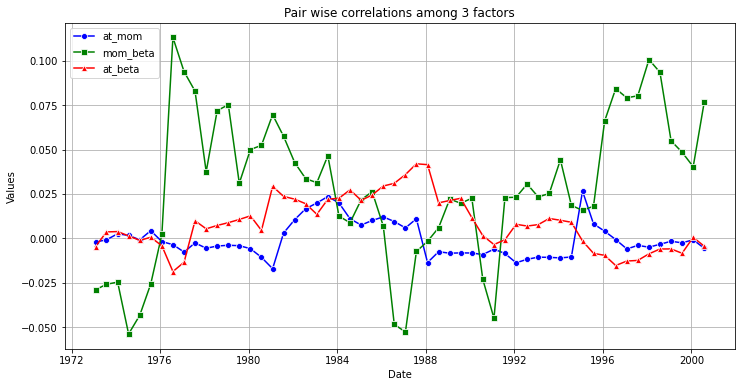

In [4]:
# Plot the pair wise correlations between the given factors
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_corr, x='date', y='at_mom', label='at_mom', marker='o', color='blue')
sns.lineplot(data=df_corr, x='date', y='mom_beta', label='mom_beta', marker='s', color='green')
sns.lineplot(data=df_corr, x='date', y='at_beta', label='at_beta', marker='^', color='red')

plt.title('Pair wise correlations among 3 factors')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

- **at_mom**: This correlation shows a general tendency to fluctuate around zero, which suggests a relatively weak or inconsistent relationship between the other two factors over the time period shown. It demonstrates small ups and downs without any substantial spikes, indicating that any interdependencies might not be strongly influential or are subject to quick changes.
- **mom_beta**: It shows substantial variability, with significant peaks and troughs. The high peaks appear around 1977 which suggest periods during which the relationship between the factors becomes stronger.However, the correlation took a gradually decline until it reached the deep troughs, particularly around the late 1980s. This means that during this period, the correlations between factors are weak. The correlations began to grow rapidly again in 1993.
- **at_beta**: This correlation displays less extreme fluctuation compared to 'mom_beta' but does show a trend of moving from generally positive in the earlier years towards more mixed or neutral correlation in the later years. The overall trend suggests that whatever relationship the factors had initially, it became less predictable and weaker as time progressed.

**The correlation coefficients are generally very low (absolute values <<0.3) and fluctuate heavily over time. The latter would be one reason for regular relebancing of portfolios.**

In [5]:
# Excluding factors that have more than 25% of missing values
factors_nan_ratio = factors.isna().mean()
factors_to_keep = factors_nan_ratio[factors_nan_ratio <= 0.25].index
factors = factors[factors_to_keep]

# Normalising the factors 
factors = (factors - factors.mean()) / factors.std()

# Filling missing values with 0
factors = factors.fillna(0)
factors.head()

me   me_lag1  me_company       prc  \
id             date                                                   
comp_001000_01 1970-10-31 -0.144122 -0.144894   -0.143834 -0.026416   
comp_001002_01 1971-12-31 -0.148891 -0.149347   -0.148505 -0.040504   
               1972-01-31 -0.148720 -0.149372   -0.148337 -0.038099   
comp_001004_01 1970-07-31 -0.148459 -0.148996   -0.148082 -0.029852   
               1970-08-31 -0.147814 -0.148932   -0.147450 -0.019200   

                           prc_local    dolvol       ret  ret_local   ret_exc  \
id             date                                                             
comp_001000_01 1970-10-31  -0.026416  0.000000  0.037727   0.037727  0.038103   
comp_001002_01 1971-12-31  -0.040504  0.000000 -0.031178  -0.031177 -0.029258   
               1972-01-31  -0.038099  0.000000  0.084648   0.084648  0.086824   
comp_001004_01 1970-07-31  -0.029852 -0.117268  0.012607   0.012606  0.013040   
               1970-08-31  -0.019200 -0.116823  0.277933   0.277932  0.278248   

                           ret_lag_dif  ...  rvol_21d  rskew_21d  ami_126d  \
id             date                     ...                                  
comp_001000_01 1970-10-31          0.0  ...       0.0        0.0       0.0   
comp_001002_01 1971-12-31          0.0  ...       0.0        0.0       0.0   
               1972-01-31          0.0  ...       0.0        0.0       0.0   
comp_001004_01 1970-07-31          0.0  ...       0.0        0.0       0.0   
               1970-08-31          0.0  ...       0.0        0.0       0.0   

                           beta_252d  ivol_capm_252d  betadown_252d  \
id             date                                                   
comp_001000_01 1970-10-31        0.0             0.0            0.0   
comp_001002_01 1971-12-31        0.0             0.0            0.0   
               1972-01-31        0.0             0.0            0.0   
comp_001004_01 1970-07-31        0.0             0.0            0.0   
               1970-08-31        0.0             0.0            0.0   

                           prc_highprc_252d  rvol_252d  qmj_prof  qmj_safety  
id             date                                                           
comp_001000_01 1970-10-31               0.0        0.0 -0.274335   -1.074606  
comp_001002_01 1971-12-31               0.0        0.0  0.490244   -0.612707  
               1972-01-31               0.0        0.0  0.453102   -0.611688  
comp_001004_01 1970-07-31               0.0        0.0 -1.650160   -1.128667  
               1970-08-31               0.0        0.0 -1.644517   -1.119755  

[5 rows x 261 columns]

In [6]:
# fit a ridge regression for a given level of alpha
def predict_ridge(X_train, y_train, X_test, alpha):
    """
    X_train: Training data set inputs
    y_train: Training data set output
    X_test: Test data set inputs
    alpha: level of alpha
    
    returns predictions for test data
    """
    # BEGIN - YOUR CODE GOES HERE
    model = Ridge(alpha, solver="lsqr")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

In [7]:
""" use a rolling window to estimate a ridge regression model based on the last 3 years data 
to predict the return over the next 12 months, assuming the portfolio is rebalanced every year"""

# prepare empty dataframe to store the results
df_pred = pd.DataFrame()

# values of the logarithm (base 10) of alpha
log_alphas = np.linspace(-5, 5, 11)
window = 36
retrain_freq = 12
dates = factors.index.get_level_values('date').to_period('M').to_timestamp('M')
dates = np.sort(np.unique(dates))
alphas = 10 ** log_alphas
for t in range(window, dates.shape[0], retrain_freq):
    train_start = dates[t - window]
    train_end = dates[t]
    test_start = dates[t]
    # prevent out-of-bounds error 
    test_end = dates[min(t + retrain_freq, len(dates)-1)] 
    
    idx_train = (factors.index.get_level_values('date') 
                 >= train_start) & (factors.index.get_level_values('date') < train_end)
    idx_test = (factors.index.get_level_values('date') 
                >= test_start) & (factors.index.get_level_values('date') < test_end)
    
    X_train = factors.loc[idx_train,:]
    y_train = future_return.loc[idx_train, :]
    X_test = factors.loc[idx_test, :]
    y_test = future_return.loc[idx_test, :]
    
    df_temp = pd.DataFrame(index=y_test.index)
    df_temp['ret_future'] = y_test.values
    for log_alpha, alpha in zip(log_alphas, alphas):
        predictions = predict_ridge(X_train, y_train, X_test, alpha)
        df_temp[f'logalpha_{log_alpha:.1f}'] = predictions
    df_pred = pd.concat([df_pred, df_temp])
df_pred  

ret_future  logalpha_-5.0  logalpha_-4.0  \
id             date                                                   
comp_001135_01 1973-03-31   -0.225341       0.013635       0.013635   
comp_001288_01 1973-03-31   -0.085002      -0.008425      -0.008425   
comp_001556_01 1973-07-31   -0.035925       0.002685       0.002685   
comp_001637_01 1973-04-30   -0.430841      -0.011651      -0.011651   
comp_001742_01 1973-02-28   -0.050993      -0.006275      -0.006275   
...                               ...            ...            ...   
crsp_92284     2000-07-31    0.137118       0.007923       0.007923   
crsp_92655     2000-04-28    0.113306       0.016057       0.016057   
               2000-08-31    0.039881      -0.012586      -0.012586   
crsp_92663     2000-12-29    0.105051      -0.026255      -0.026254   
crsp_92807     2000-01-31   -0.080766      -0.031552      -0.031552   

                           logalpha_-3.0  logalpha_-2.0  logalpha_-1.0  \
id             date                                                      
comp_001135_01 1973-03-31       0.013634       0.013625       0.013538   
comp_001288_01 1973-03-31      -0.008425      -0.008431      -0.008483   
comp_001556_01 1973-07-31       0.002685       0.002681       0.002642   
comp_001637_01 1973-04-30      -0.011650      -0.011638      -0.011523   
comp_001742_01 1973-02-28      -0.006273      -0.006257      -0.006096   
...                                  ...            ...            ...   
crsp_92284     2000-07-31       0.007923       0.007923       0.011918   
crsp_92655     2000-04-28       0.016058       0.016067       0.016974   
               2000-08-31      -0.012584      -0.012574      -0.011471   
crsp_92663     2000-12-29      -0.026252      -0.026229      -0.024871   
crsp_92807     2000-01-31      -0.031550      -0.031539      -0.032677   

                           logalpha_0.0  logalpha_1.0  logalpha_2.0  \
id             date                                                   
comp_001135_01 1973-03-31      0.010025      0.010567      0.014706   
comp_001288_01 1973-03-31     -0.009648     -0.010347     -0.008628   
comp_001556_01 1973-07-31      0.000706      0.002365      0.010235   
comp_001637_01 1973-04-30     -0.009178     -0.004356      0.004036   
comp_001742_01 1973-02-28     -0.003984      0.001214      0.003834   
...                                 ...           ...           ...   
crsp_92284     2000-07-31      0.010417      0.005217      0.007549   
crsp_92655     2000-04-28      0.017450      0.022122      0.024194   
               2000-08-31     -0.010847     -0.006830     -0.003699   
crsp_92663     2000-12-29     -0.022939     -0.012848     -0.003625   
crsp_92807     2000-01-31     -0.031454     -0.024489     -0.018350   

                           logalpha_3.0  logalpha_4.0  logalpha_5.0  
id             date                                                  
comp_001135_01 1973-03-31      0.020615      0.009310      0.002609  
comp_001288_01 1973-03-31     -0.004959     -0.001650      0.001264  
comp_001556_01 1973-07-31      0.013214      0.007169      0.002836  
comp_001637_01 1973-04-30      0.007905      0.005155      0.002793  
comp_001742_01 1973-02-28      0.003591      0.000742      0.001038  
...                                 ...           ...           ...  
crsp_92284     2000-07-31      0.008574      0.003000      0.002650  
crsp_92655     2000-04-28      0.024375      0.018151      0.010502  
               2000-08-31     -0.000102      0.005627      0.008390  
crsp_92663     2000-12-29      0.000117      0.002085      0.004042  
crsp_92807     2000-01-31     -0.009332     -0.002600      0.002140  

[100800 rows x 12 columns]

In [8]:
""" For each level of alpha, compute the annual (unconditional) Sharpe ratio 
of a portfolio whose weights are equal to the predicted (expected) returns"""
cols = list(df_pred.columns.difference(['date', 'ret_future']))
sharpe_ratios = []
for col in cols:
    pred_ret = df_pred[col]
    ret = (df_pred['ret_future']*pred_ret).reset_index().groupby('date').sum()[0]
    annual_sharpe_ratio = np.sqrt(12) * ret.mean() / ret.std()
    sharpe_ratios.append({'alpha': col, 'sharpe_ratio': annual_sharpe_ratio})
df_sharpe = pd.DataFrame(sharpe_ratios)
best_alpha = df_sharpe.loc[df_sharpe['sharpe_ratio'].idxmax(), 'alpha']
print('Best alpha:', best_alpha)
df_sharpe

Best alpha: logalpha_3.0


,alpha,sharpe_ratio
0,logalpha_-1.0,0.053745
1,logalpha_-2.0,0.050239
2,logalpha_-3.0,0.049687
3,logalpha_-4.0,0.049677
4,logalpha_-5.0,0.049676
5,logalpha_0.0,0.066596
6,logalpha_1.0,0.093328
7,logalpha_2.0,0.118632
8,logalpha_3.0,0.292775
9,logalpha_4.0,0.208088


Text(0.5, 1.0, 'Portfolio Returns')

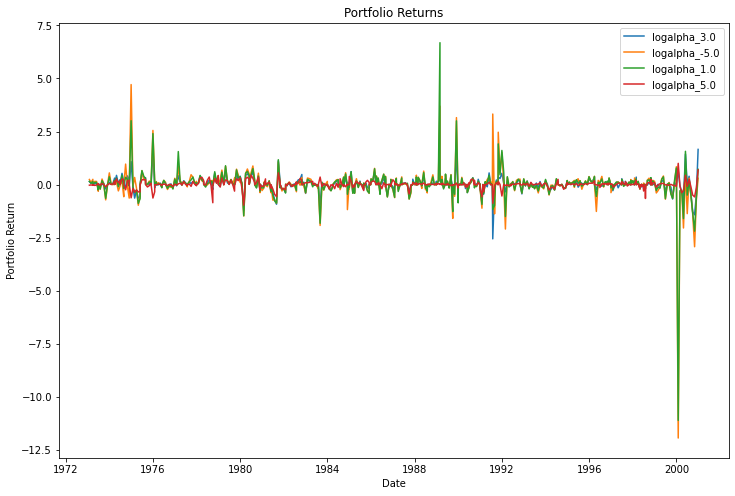

In [9]:
# portfolio returns for the level of alpha with the highest Sharpe ratio,alpha 0.00001, 1 and 100000
best_a_id = df_sharpe['sharpe_ratio'].idxmax()
best_alp = df_sharpe['alpha'].iloc[best_a_id]
alps = [best_alp, "logalpha_-5.0", "logalpha_1.0", "logalpha_5.0"]

plt.figure(figsize=(12, 8))
for alpha in alps:
    pred_ret = df_pred[alpha]
    ret = (df_pred['ret_future']*pred_ret).reset_index().groupby('date').sum()[0]
    sns.lineplot(x=ret.index, y=ret.values, label=alpha)
plt.xlabel('Date')
plt.ylabel('Portfolio Return')
plt.title('Portfolio Returns')

**Conclusion**
The greater the alpha, the greater the extent to which ridge-regression coefficients are shrunk towards zero. This means that the lower the variance, the higher the bias.

In [10]:
# Compute the expected (unconditional) Sharpe ratio of portfolios with the same levels of alpha
def portfolio_performance_exp(w, lower_bound=None):
    # create vector of weights
    w=w.clip(upper=None, lower=lower_bound)

    # make a portfolio
    direction = w/w.abs() 
    ret = (direction * w).reset_index().groupby('date').sum()
    ret = ret[ret.columns[-1]]
    
    # produce performance
    sharpe = (np.sqrt(12) * ret.mean() / ret.std())
    
    return ret, sharpe

In [11]:
df_sharpe_exp = pd.DataFrame({"log_alpha":[], "sharpe":[]})

for log_alpha in log_alphas:
    ret, sharpe = portfolio_performance_exp(df_pred[f'logalpha_{log_alpha}'])
    row = [log_alpha, sharpe]
    df_sharpe_exp.loc[len(df_sharpe_exp)] = row
    
df_sharpe_exp.iloc[df_sharpe_exp['sharpe'].idxmax()]

log_alpha    4.000000
sharpe       4.364391
Name: 9, dtype: float64

In [15]:
def portfolio_performance(w, df_ret, lower_bound=None):
    # create vector of weights
    w=w.clip(upper=None, lower=lower_bound)

    # make a portfolio
    ret = (df_ret * w).reset_index().groupby('date')[0].sum()

    # produce performance
    sharpe = (np.sqrt(12) * ret.mean() / ret.std())
    
    return ret, sharpe

Text(0, 0.5, 'Returns')

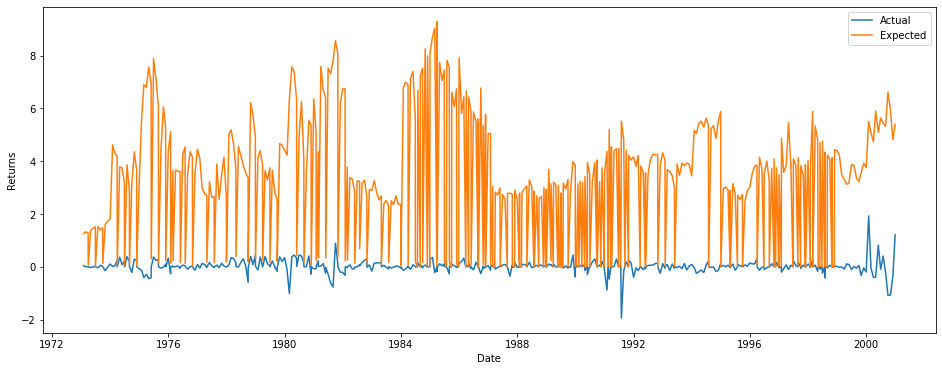

In [17]:
df_ret = df_pred['ret_future']
ret_10000, sharpe_10000 = portfolio_performance(df_pred['logalpha_4.0'], df_ret)
ret_10000_exp, sharpe_10000_exp = portfolio_performance_exp(df_pred['logalpha_4.0'])

plt.figure(figsize=(16,6))
sns.lineplot(x=ret_10000.index, y=ret_10000.values, label="Actual")
sns.lineplot(x=ret_10000_exp.index, y=ret_10000_exp.values, label="Expected")
plt.xlabel("Date")
plt.ylabel("Returns")

The choice of a higher level of alpha in the ridge regressions (used to build portfolios) increases bias, which, intuitively, means that the model captures the data generating process less well, which in turn would be expected to lead to a higher 'prediction error', which is what we see in the plot.